# 0.0. Imports

## 0.1. Libraries

In [4]:
# jupyter core
from IPython.core.display      import display, HTML
from IPython.display           import Image

# requests
from urllib.request import Request, urlopen, urlretrieve
from urllib.error import URLError, HTTPError

# scraping
from bs4 import BeautifulSoup

# data manipulation
import numpy as np
import pandas as pd
import re

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

## 0.2. Helper Functions

In [53]:
def jupyter_settings():
    !matplotlib inline
    !pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]

    plt.rcParams['font.size'] = 12
    
    display(HTML("<style>.container { width:100% !important; }</style>"))
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [49]:
jupyter_settings()

'matplotlib' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.
'pylab' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


## 0.3. Data Scraper

### Request test

In [5]:
# request test
url = 'https://rn.olx.com.br/rio-grande-do-norte/natal/imoveis/aluguel/apartamentos?o=1'
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36'}
try:
    req = Request(url, headers=headers)
    response = urlopen(req)
    html = response.read().decode('utf-8')
    print('OK')
except HTTPError as e:
    print(e.status, e.reason)
    
except URLError as e:
    print(e.reason)

OK


### Scraper

In [6]:
# scraping
pages = 29

# list, receiver of info from each renting ad, as a dictionaire
cards = []

for i in range(pages):
    # requesting html
    headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36'}
    req = Request('https://rn.olx.com.br/rio-grande-do-norte/natal/imoveis/aluguel/apartamentos?o=' + str(i + 1), headers=headers)
    response = urlopen(req)
    html = response.read().decode('utf-8')
    
    # scraper
    soup = BeautifulSoup(html, 'html.parser')
    anuncios = soup.find('div', {"id": "column-main-content"}).findAll('div', class_="fnmrjs-2 jiSLYe")
    
    for anuncio in anuncios:
        card = {}
        
        # name
        card['NOME'] = anuncio.find("h2").getText()
        
        # value
        span_valor = anuncio.find("span", class_="sc-ifAKCX eoKYee")
        card["VALOR"] = span_valor.get_text() if span_valor else ''
        
        # details
        span_detalhe = anuncio.find("span", class_="sc-1j5op1p-0 lnqdIU sc-ifAKCX eLPYJb")
        card['DETALHES'] = span_detalhe.get_text().split('|') if span_detalhe else ''
        
        # address
        span_endereco = anuncio.find('span', class_="sc-7l84qu-1 ciykCV sc-ifAKCX dpURtf")
        card['ENDEREÇO'] = span_endereco.getText().split(', ')[1] if span_endereco else ''
        
        # appending list values to dict
        cards.append(card)    
    
# saving csv (or json, )
df_raw = pd.DataFrame(cards)
df_raw.head()

,NOME,VALOR,DETALHES,ENDEREÇO
0,LC - Apartamento em Ponta Negra!,R$ 1.500,"[2 quartos , 58m² , 1 vaga]",Ponta Negra
1,"Alugo apartamento no Alecrim, sua casa no cent...",R$ 650,"[2 quartos , 50m²]",Alecrim
2,LCAP2201 - Ótimo apartamento em Tirol!,R$ 3.600,"[2 quartos , 200m² , 2 vagas]",Barro Vermelho
3,Kitnet UFRN cidade jardim capim macio,R$ 800,,Capim Macio
4,Kitinet excelente localização Ponta Negra,R$ 2.500,"[1 quarto , 14m² , Condomínio: R$ 0]",Ponta Negra


In [21]:
df_raw.to_csv('df_raw.csv')

In [55]:
df_raw['DETALHES'].head(40)

0                         [2 quartos ,  58m² ,  1 vaga]
1                                   [2 quartos ,  50m²]
2                       [2 quartos ,  200m² ,  2 vagas]
3                                                      
4                [1 quarto ,  14m² ,  Condomínio: R$ 0]
5                                  [1 quarto ,  1 vaga]
6                                  [1 quarto ,  1 vaga]
7      [1 quarto ,  30m² ,  Condomínio: R$ 0 ,  1 vaga]
8     [2 quartos ,  61m² ,  Condomínio: R$ 595 ,  1 ...
9     [2 quartos ,  43m² ,  Condomínio: R$ 0 ,  1 vaga]
10                        [2 quartos ,  76m² ,  1 vaga]
11            [2 quartos ,  Condomínio: R$ 0 ,  1 vaga]
12                                   [2 quartos ,  0m²]
13                        [2 quartos ,  57m² ,  1 vaga]
14    [2 quartos ,  49m² ,  Condomínio: R$ 0 ,  1 vaga]
15                         [2 quartos ,  0m² ,  1 vaga]
16                         [2 quartos ,  0m² ,  1 vaga]
17                        [2 quartos ,  57m² ,  

# Data Cleaning

In [58]:
df1 = df_raw.copy()

In [59]:
df1.shape

(1448, 4)

In [60]:
df1.dtypes

NOME        object
VALOR       object
DETALHES    object
ENDEREÇO    object
dtype: object

### Regex em DETALHES

In [61]:
# lambda functions and mapping the column DETALHES to separate each section
f_quarto = lambda x: re.findall('[0-9]+ quartos?', str(x))
f_area = lambda x: re.findall('[0-9]+m²', str(x))
f_condominio = lambda x: re.findall('Condomínio: R\$\ [0-9]+', str(x))
f_vaga = lambda x: re.findall('[0-9]+ vagas?', str(x))

df1['QUARTOS'] = list(map(f_quarto, df1['DETALHES']))
df1['AREA'] = list(map(f_area, df1['DETALHES']))
df1['CONDOMINIO'] = list(map(f_condominio, df1['DETALHES']))
df1['VAGAS'] = list(map(f_vaga, df1['DETALHES']))

df1.head()

,NOME,VALOR,DETALHES,ENDEREÇO,QUARTOS,AREA,CONDOMINIO,VAGAS
0,LC - Apartamento em Ponta Negra!,R$ 1.500,"[2 quartos , 58m² , 1 vaga]",Ponta Negra,[2 quartos],[58m²],[],[1 vaga]
1,"Alugo apartamento no Alecrim, sua casa no cent...",R$ 650,"[2 quartos , 50m²]",Alecrim,[2 quartos],[50m²],[],[]
2,LCAP2201 - Ótimo apartamento em Tirol!,R$ 3.600,"[2 quartos , 200m² , 2 vagas]",Barro Vermelho,[2 quartos],[200m²],[],[2 vagas]
3,Kitnet UFRN cidade jardim capim macio,R$ 800,,Capim Macio,[],[],[],[]
4,Kitinet excelente localização Ponta Negra,R$ 2.500,"[1 quarto , 14m² , Condomínio: R$ 0]",Ponta Negra,[1 quarto],[14m²],[Condomínio: R$ 0],[]


In [113]:
# lambda function and mapping to extract the number to count each feature
f1_quarto = lambda x: re.findall('[0-9]+', str(x))
f1_area = lambda x: re.findall('[0-9]+', str(x))
f1_condominio = lambda x: re.findall('[0-9]+', str(x))
f1_vaga = lambda x: re.findall('[0-9]+', str(x))
f1_valor = lambda x: re.findall('[0-9]+', str(x))

df1['QUARTOS'] =  list(map(f1_quarto, df1['QUARTOS']))
df1['AREA'] = list(map(f1_area, df1['AREA']))
df1['CONDOMINIO'] = list(map(f1_condominio, df1['CONDOMINIO']))
df1['VAGAS'] = list(map(f1_vaga, df1['VAGAS']))
df1['VALOR'] = list(map(f1_valor, df1['VALOR']))

df1.head()

,NOME,VALOR,DETALHES,ENDEREÇO,QUARTOS,AREA,CONDOMINIO,VAGAS
0,LC - Apartamento em Ponta Negra!,"[1, 500]","[2 quartos , 58m² , 1 vaga]",Ponta Negra,[2],[58],[],[1]
1,"Alugo apartamento no Alecrim, sua casa no cent...",[650],"[2 quartos , 50m²]",Alecrim,[2],[50],[],[]
2,LCAP2201 - Ótimo apartamento em Tirol!,"[3, 600]","[2 quartos , 200m² , 2 vagas]",Barro Vermelho,[2],[200],[],[2]
3,Kitnet UFRN cidade jardim capim macio,[800],,Capim Macio,[],[],[],[]
4,Kitinet excelente localização Ponta Negra,"[2, 500]","[1 quarto , 14m² , Condomínio: R$ 0]",Ponta Negra,[1],[14],[0],[]


### Cleaning Helper Functions

In [63]:
def list_quartos(n):
    # lista com numeros de quartos
    lst = []
    
    # iterando as strings com valores de numeros de quarto
    for i in n:
        if len(i)>3:
            lst.append(i[-3])
        else:
            lst.append('1') #valores vazios são interpretados como kitnets e insere-se 1 quarto
    
    # convertendo o valor numerico de str para numero
    lst = pd.Series(pd.to_numeric(lst))
    
    return lst

def list_vagas(n):
    # lista com numeros de vagas
    lst = []
    
    # iterando as strings com valores de numeros de quarto
    for i in n:
        if len(i)>3:
            lst.append(i[-3])
        else:
            lst.append('0') #valores vazios são interpretados como 0 vaga
    
    # convertendo o valor em str para numerico int
    lst = pd.Series(pd.to_numeric(lst))
    
    return lst

def list_cond(n):
    # lista com valores de condominio
    lst = []
    
    # iterando as strings com valores de condominio
    for i in n:
        if len(i)>2:
            lst.append(''.join(re.findall('[0-9]+', i)))
        else:
            lst.append(0)
    
    # convertendo os valores em str para numerico int
    lst = pd.Series(pd.to_numeric(lst))
    
    return lst

def list_area(n):
    # lista com valores de area
    lst = []
    
    # iterando as strings com valores de area
    for i in n:
        if len(i)>2:
            lst.append(''.join(re.findall('[0-9]+', i)))
        else:
            lst.append(0)
    
    # convertendo os valores em str para numerico int
    lst = pd.Series(pd.to_numeric(lst))
    
    return lst

### Quartos

In [13]:
list_quartos(df1['QUARTOS'].astype(str))

0       2
1       2
2       2
3       1
4       1
       ..
1443    3
1444    2
1445    1
1446    4
1447    2
Length: 1448, dtype: int64

### Vagas

In [14]:
list_vagas(df1['VAGAS'].astype(str))

0       1
1       0
2       2
3       0
4       0
       ..
1443    2
1444    1
1445    0
1446    3
1447    0
Length: 1448, dtype: int64

### Condominio

In [68]:
list_cond(df1['CONDOMINIO'].astype(str))

0       0
1       0
2       0
3       0
4       0
       ..
1443    0
1444    0
1445    0
1446    0
1447    0
Length: 1448, dtype: int64

### Área

In [16]:
list_area(df1['AREA'].astype(str))

0        58
1        50
2       200
3         0
4        14
       ... 
1443      0
1444     46
1445     18
1446    176
1447     57
Length: 1448, dtype: int64

### Valor

In [109]:
df2 = pd.DataFrame()

df2['NOME'] = df1['NOME']
df2['ENDERECO'] = df1['ENDEREÇO']
df2['QUARTOS'] = list_quartos(df1['QUARTOS'].astype(str))
df2['VAGAS'] = list_vagas(df1['VAGAS'].astype(str))
df2['CONDOMINIO'] = list_cond(df1['CONDOMINIO'].astype(str))
df2['AREA'] = list_area(df1['AREA'].astype(str))
df2['VALOR'] = df1['VALOR']

df2.head()

,NOME,ENDERECO,QUARTOS,VAGAS,CONDOMINIO,AREA,VALOR
0,LC - Apartamento em Ponta Negra!,Ponta Negra,2,1,0,58,R$ 1.500
1,"Alugo apartamento no Alecrim, sua casa no cent...",Alecrim,2,0,0,50,R$ 650
2,LCAP2201 - Ótimo apartamento em Tirol!,Barro Vermelho,2,2,0,200,R$ 3.600
3,Kitnet UFRN cidade jardim capim macio,Capim Macio,1,0,0,0,R$ 800
4,Kitinet excelente localização Ponta Negra,Ponta Negra,1,0,0,14,R$ 2.500


In [110]:
df2.to_csv('df_clean.csv', index=None)

# Data Description

### Description Helper Functions

In [69]:
def num_analysis(num_attributes):
    # Cemtral tendency - mean, median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # concatenate
    m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
    m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
    
    # histogram
    num_hist = num_attributes.hist(bins=30)
    
    # DataFrame
    return m
    
    # Histogram
    return num_hist

In [111]:
df3 = df2.copy()

In [112]:
df3.dtypes

NOME          object
ENDERECO      object
QUARTOS        int64
VAGAS          int64
CONDOMINIO     int64
AREA           int64
VALOR         object
dtype: object

In [72]:
df3.head()

# filter for area less than 200 m²
# data description for condominio above R$ 50

,NOME,ENDERECO,QUARTOS,VAGAS,CONDOMINIO,AREA
0,LC - Apartamento em Ponta Negra!,Ponta Negra,2,1,0,58
1,"Alugo apartamento no Alecrim, sua casa no cent...",Alecrim,2,0,0,50
2,LCAP2201 - Ótimo apartamento em Tirol!,Barro Vermelho,2,2,0,200
3,Kitnet UFRN cidade jardim capim macio,Capim Macio,1,0,0,0
4,Kitinet excelente localização Ponta Negra,Ponta Negra,1,0,0,14


In [85]:
df3 = df3[(df3['AREA']<=200)]
df3.shape

(1390, 6)

In [86]:
num_attributes = df3.select_dtypes(include = ['int64'])
cat_attributes = df3.select_dtypes(include = ['object'])

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,QUARTOS,1.0,4.0,3.0,2.028777,2.0,0.786966,0.277289,-0.596720
1,VAGAS,0.0,4.0,4.0,1.031655,1.0,0.749392,0.595237,0.622742
2,CONDOMINIO,0.0,950.0,950.0,73.852518,0.0,180.461963,2.493657,5.430296
3,AREA,0.0,200.0,200.0,55.794245,56.0,39.655016,0.793654,1.327402


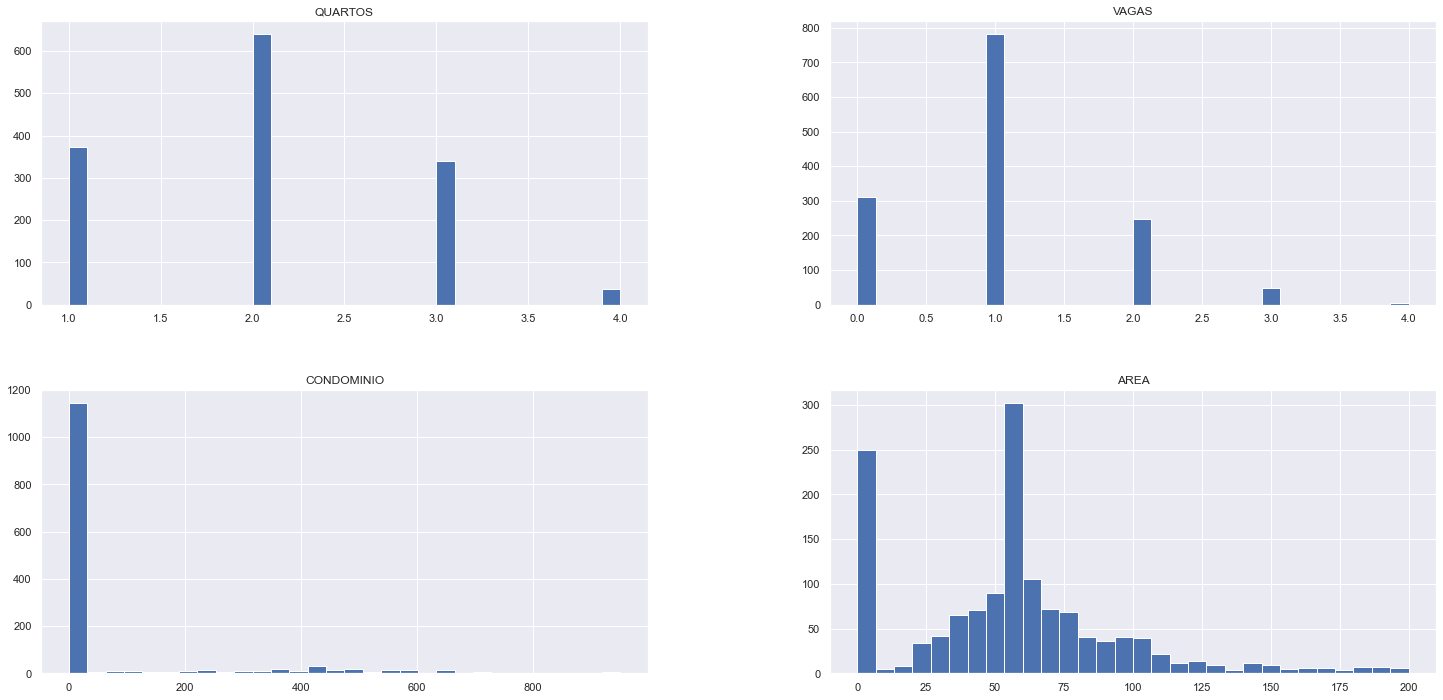

In [87]:
num_analysis(num_attributes)

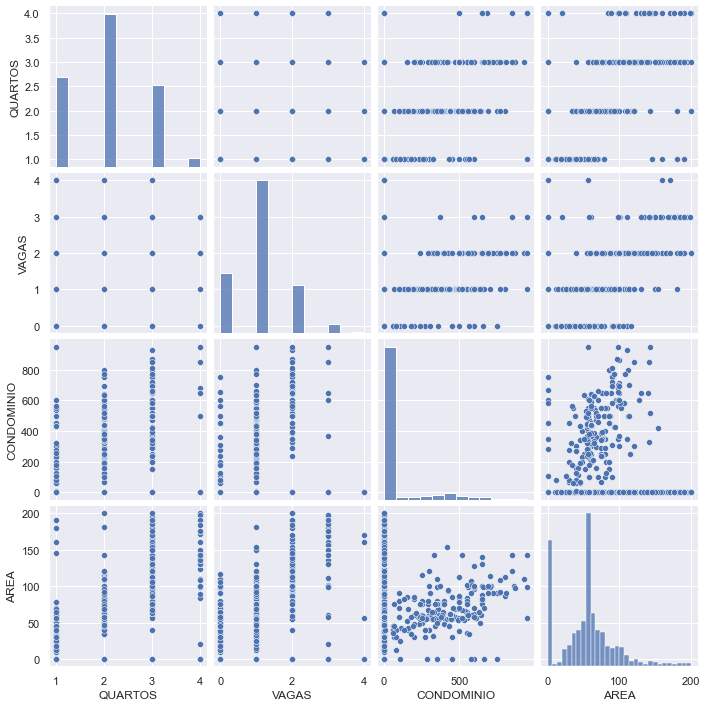

In [88]:
sns.pairplot(num_attributes)

In [95]:
cat_attributes.apply(lambda x: x.unique().shape)

,NOME,ENDERECO
0,1336,31


In [96]:
cat_attributes['ENDERECO'].unique()

array(['Ponta Negra', 'Alecrim', 'Barro Vermelho', 'Capim Macio',
       'Nossa Senhora de Nazaré', 'Nossa Senhora da Apresentação',
       'Lagoa Nova', 'Neópolis', 'Pitimbu', 'Candelária', 'Tirol',
       'Dix-Sept Rosado', 'Rocas', 'Nova Descoberta', 'Cidade Alta',
       'Petrópolis', 'Felipe Camarão', 'Quintas', 'Areia Preta',
       'Planalto', 'Pajuçara', 'Cidade da Esperança', 'Bom Pastor',
       'Praia do Meio', 'Ribeira', 'Potengi', 'Lagoa Azul', 'Cidade Nova',
       'Lagoa Seca', 'Redinha', 'Igapó'], dtype=object)

### Bairros de interesse

In [97]:
bairros = ['Ponta Negra','Capim Macio','Petrópolis','Lagoa Nova']

In [104]:
df4 = df3[df3['ENDERECO'].str.contains('Capim Macio|Ponta Negra|Petrópolis')]

df4.shape

(628, 6)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,QUARTOS,1.0,4.0,3.0,2.009554,2.0,0.740054,0.221091,-0.543939
1,VAGAS,0.0,4.0,4.0,1.044586,1.0,0.649291,0.551237,1.482963
2,CONDOMINIO,0.0,950.0,950.0,45.952229,0.0,148.038978,3.402580,11.293001
3,AREA,0.0,188.0,188.0,52.980892,56.0,31.677258,0.318214,1.202289


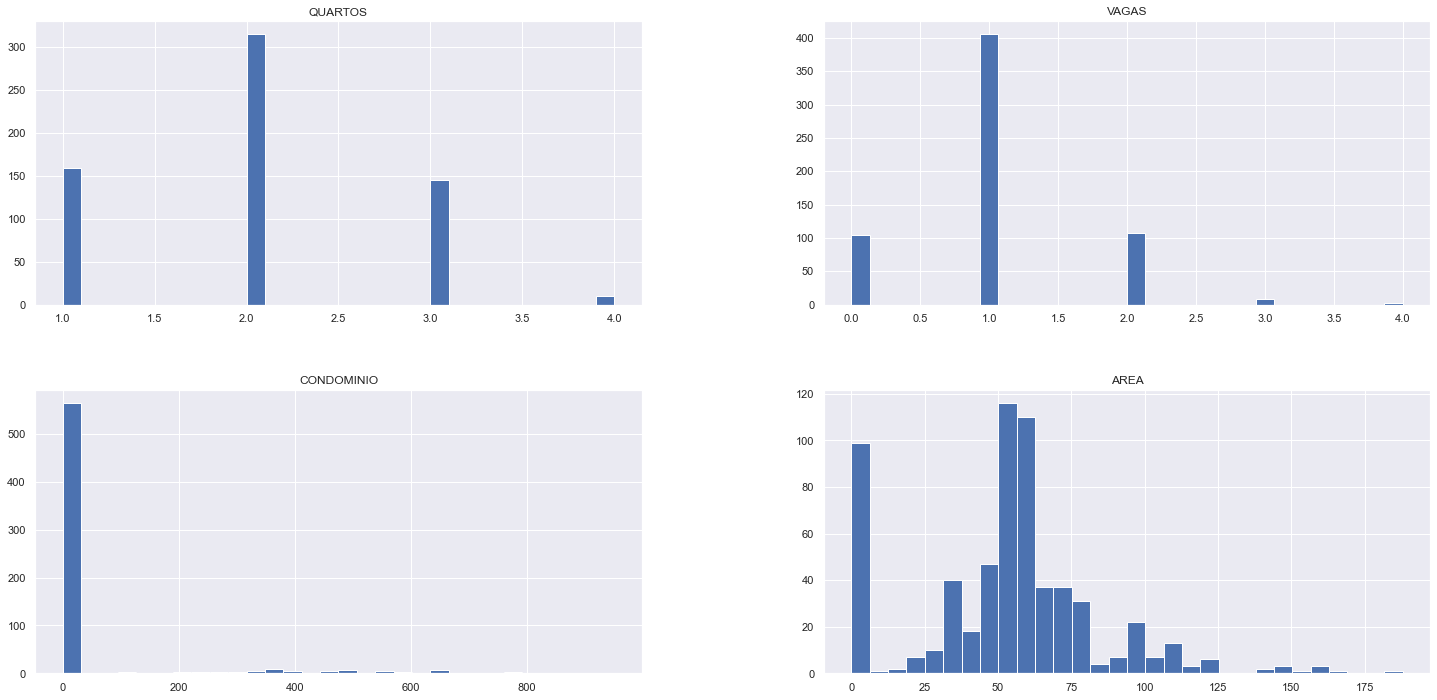

In [107]:
num_attributes = df4.select_dtypes(include = ['int64'])
cat_attributes = df4.select_dtypes(include = ['object'])

num_analysis(num_attributes)

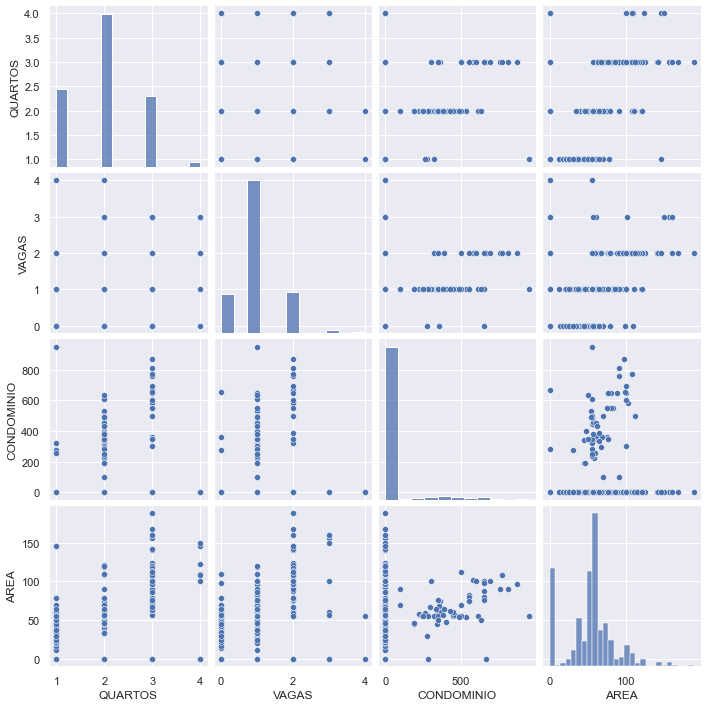

In [108]:
sns.pairplot(num_attributes)

In [ ]:
sns.boxplot(x='')